#**Airlines Tweets Sentiment Analysis**

This code will explore the Tweets sentiment analysis dataset from kaggle. The dataset detail could be found in this sites :



```
https://www.kaggle.com/crowdflower/twitter-airline-sentiment
```

The data was stored in my personal drive. The classification include the sentiment (Positive, Negative and Introgative), The reason of such sentiment and many more.

There are two goal in this tutorial. Each goal will have different solution or model. The goal achived by performing the deep learning algorithm on tweets word. In this tutorial we will utilize **Keras** deep learning package.

To optimize the value accuracy of the model, this tutorial will use **Keras-tuner** to tune the best hyperparameter to train the model.



##**Parameter**

Here is the parameter that we will be used to analyze the dataset :

###**X**
X parameter is the parameter used to train the deep learning. In this case we used text column from the dataset.

*   **text** = What the tweet said

###**Y1**


Y1 goal is to predict the sentiment of the text.

*   **airline sentiment**   = [negative (-1), neutral (0), positive(1)]

###**Y2**


Y2 goal is redict the reason of such complaint.

*   **negativereason** = the reason why it is negative.










In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud,STOPWORDS

#========= Install keras-tuner package ===========
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner import HyperModel
import pickle

#========= Import The Dataset ===========

from google.colab import drive
drive.mount('/content/gdrive')
path='gdrive/My Drive/Colab Notebooks/Tweets.csv'
tweets=pd.read_csv(path, delimiter=',')
tweets.head(20)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


##**Data Exploration**

This section will graph how many instance of certain sentiment and also the negative reason.

It seems that the negative sentiment dominate the dataset. The reason for those negative sentiment mostly resulted from bad costumer service. However, there are no specific pattern why a certain airline receive more negative sentiment than the other.

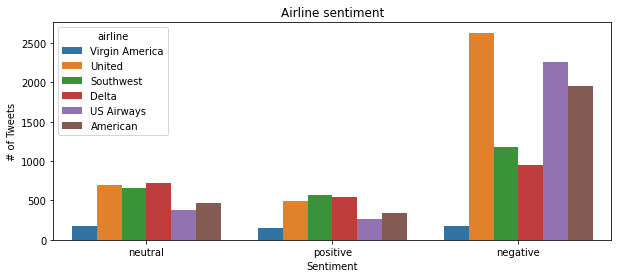

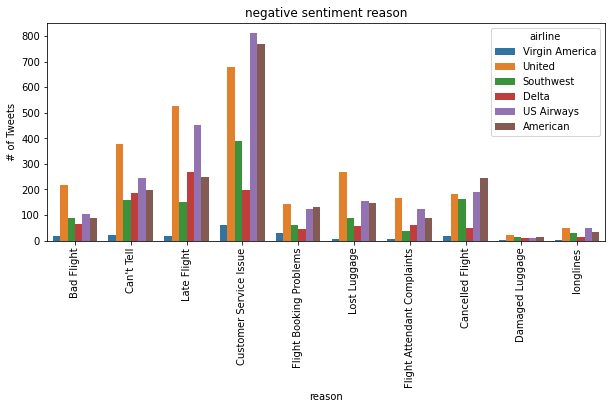

In [ ]:
plt.figure(1,figsize=(10,4))
sns.countplot(x=tweets['airline_sentiment'],hue=tweets['airline'])
plt.title('Airline sentiment')
plt.xlabel('Sentiment')
plt.ylabel('# of Tweets')
plt.show()

plt.figure(1,figsize=(10,4))
sns.countplot(x=tweets['negativereason'],hue=tweets['airline'])
plt.title('negative sentiment reason')
plt.xlabel('reason')
plt.ylabel('# of Tweets')
plt.xticks(rotation=90)
plt.show()

##**Dataset Pre-processing**

Before we proceed to the program we need to cleanup the text from webpage, hashtag and emoji. Those character are not mean anything related to sentiment, thus it will reduce the accuracy of our model.

For this purpose we create some function/def.

###**1. Deemojify**
This function will erase almost all of the emjoji based on its unicode. This function was adopted from this stackoverflow thread.



```
https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
```

This def/function used inside the other function.

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

###**2. Text cleanup**

This function will erase the symbol, special character, single character, and multiple space. The function will split the tweets and detect if there are any certain character inside the splitted tweets.

The function will also create the word cloud graph for every instances of sentiment or negative reason.

In [ ]:
def text_conditioning(tweets,columns,restriction,plot=True):
  data_1=tweets[columns].copy()
  lister=[]
  for j in range(0,len(data_1)):
    listes=data_1['text'].iloc[j].split()
    for k in restriction:
      listes=[l for l in listes if k not in l]
    listes=deEmojify(' '.join(listes))

    listes=re.sub(r'\W', ' ', listes)
    listes=re.sub(r'\s+[a-zA-Z]\s+',' ',listes)
    listes=re.sub(r'^[a-zA-Z]\s+',' ', listes)
    listes=re.sub(r'\s+',' ', listes, flags=re.I)
    listes=listes.lower()

    lister.append(listes)
  data_1['text']=lister

  if plot==True:
    plt.figure(1,figsize=(12,4)); cnt=1

    for m in np.unique(tweets[columns[0]]):
      words=" ".join(data_1[np.array(data_1[columns[0]])==m]['text'])
      wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',
                            width=600,height=500).generate(words)
      plt.subplot(1,3,cnt)
      plt.title(m+' words')
      plt.imshow(wordcloud)
      plt.axis('off')
      cnt+=1
    plt.show()

  return(data_1)

###**3. Datasplit by Sentiment**

This function will split the dataset by the sentiment. This function is usefull if we want to analyze each sentiment individually, especially when analyzing negative sentiment reason.

In [ ]:
def sentiment_datasplit (data_1,y):
  #data_1[y]=data_1[y].replace(['neutral'],0)
  #data_1[y]=data_1[y].replace(['negative'],-1)
  #data_1[y]=data_1[y].replace(['positive'],1)

  neg_data=data_1[data_1.airline_sentiment == 'negative'].copy().drop([y],axis=1)
  pos_data=data_1[data_1.airline_sentiment == 'positive'].copy().drop([y],axis=1)
  ntl_data=data_1[data_1.airline_sentiment == 'neutral'].copy().drop([y],axis=1)

  return(data_1,neg_data,pos_data,ntl_data)

#**$1^{st}$ model**#

Before we train the model, we need to tune the hyperparameter. Keras-tuner will try each of the hyperparameter mentioned in class and find the best model with the greatest value accuracy. The model will not be the same for each time the tuning performed due to the stochastic behaviour of the model.

Hyperparameter

*   **learning rate**
*   **dropout rate**
*   **neurons dense**
*   **batch size**
*   **epoch**

The neuron layers will include:

*   Dense input layer (size = vocabulary size in dataset)
*   3 layer of Dense with Dropout ( 3 layer choosen because we have three different value of sentiment)
*   Dense  output layer (size = different value of sentiment)

All the layer uses **relu** activation except the last layer in which uses **softmax**.


In [ ]:
class Tuning(HyperModel):
  def __init__ (self,vocabulary_size,input_size,label):
    self.vocabulary_size= vocabulary_size
    self.input_size= input_size
    self.label=label

  def build(self,params):
    learning_rate   =params.Float('learning_rate',min_value=1e-4, max_value=0.5, sampling='log')
    dropout_rate    =params.Float('dropout_rate',min_value=1e-2, max_value=0.5, sampling='log')
    neurons_density =params.Int('neuron_dense',min_value=1, max_value=10)
    model=Sequential()
    model.add(layers.Dense(neurons_density,input_shape=(self.vocabulary_size,)))
    model.add(layers.Activation('relu'))

    for i in range(0,self.label):
      model.add(layers.Dropout(dropout_rate))
      model.add(layers.Dense(neurons_density))
      model.add(layers.Activation('relu'))

    model.add(layers.Dense(self.label))
    model.add(layers.Activation('softmax'))

    optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

*Incase of fail we can remove the model folder in colab disk*

In [ ]:
!rm -rf ./sentiment

###**Preprocess the dataset**

Every word with @, http, #, &gt, &amp and RT will be removed from dataset.

As we can see from the cloud, the great, awesome and love dominated the posituve sentiment and the negative word dominated by noun related to the reason such as bag, plane and hour.

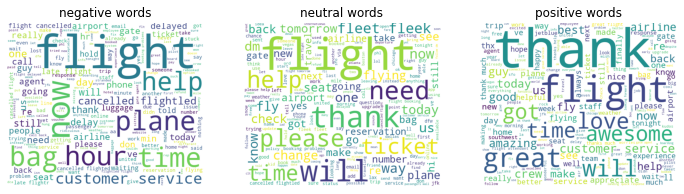

In [ ]:
restriction=['@','http','#','&gt','&amp','RT']
columns    =['airline_sentiment','text']
x_col,y_col=[columns[1],columns[0]]
data_1           =text_conditioning(tweets,columns,restriction)
data_1           =sentiment_datasplit (data_1,y_col)[0]

###**Tokenize binarily**

The train size for this cases is 80% thus the test size is 0.2. We also limits the amount of vocabulary to reduce unecessary vocabulary. The model will only be given 80% most frequent vocabulary.

Tokenizer from scikit-learn was used to give each word integer based on tihe vocabulary frequency. Since we will use binary value, each word in a tweets will be made into a matrix with dimension of vocabulary. If a certain word not in the text then the matrix coresponding to the word will give 0 value and vice-versa. The same thing also done for the sentiment with binary encoder from scikit-learn.

In [ ]:
test_size  =0.2
lexi_size  =0.8

df_train,df_tests=train_test_split(data_1,test_size=test_size)

x_train = df_train[x_col].values
y_train = df_train[y_col].values

x_tests = df_tests[x_col].values
y_tests = df_tests[y_col].values

vocab   =len(np.unique(np.concatenate(np.array([i.split() for i in x_train]))))

#========== Tokenize and Binarizing the Tweets===========
tokenizer=Tokenizer(num_words=int(vocab*lexi_size))
tokenizer.fit_on_texts(x_train)
x_train=tokenizer.texts_to_matrix(x_train,mode='tfidf')
x_tests=tokenizer.texts_to_matrix(x_tests,mode='tfidf')

#========== Binarizing the Sentiment===========
encoder=LabelBinarizer()
encoder.fit(y_train)
y_train=encoder.transform(y_train)
y_tests=encoder.transform(y_tests)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


###**Tune**

Now we initiate the model class by its vocabulary size, input size and the label size (number of different value of sentiment). The objective for this tune is value accuracy.

If somehow value loss is increasing, the tuning process will stop after the last 5 epochs showed value loss increase.

In [ ]:
#========== Setup Tune Class ============
hpmodel= Tuning(vocabulary_size=int(vocab*lexi_size), input_size=len(x_train[0]),
                label=len(df_train[y_col].unique()))
tuner  = kt.Hyperband(hpmodel,objective='val_accuracy',
                      max_epochs=5000,factor=100,project_name='sentiment')

#========== Initiate the Callbacks ============
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#========== Start ============
tuner.search(x_train,y_train,epochs=1000,validation_data=(x_tests,y_tests),callbacks=[stop_early])

#========== Result ============
#tuner.results_summary()
best_model=tuner.get_best_hyperparameters(num_trials=1)[0]

learning_rate   = best_model.get('learning_rate')
dropout_rate    =best_model.get('dropout_rate')
neurons_density =best_model.get('neuron_dense')

print('learning rate \t = ',learning_rate)
print('dropout rate \t = ',dropout_rate)
print('neurons dense \t = ',neurons_density)

Trial 155 Complete [00h 00m 11s]
val_accuracy: 0.7892759442329407

Best val_accuracy So Far: 0.806352436542511
Total elapsed time: 00h 42m 42s
INFO:tensorflow:Oracle triggered exit
learning rate 	 =  0.001004862274430443
dropout rate 	 =  0.010979620031373743
neurons dense 	 =  9


###**Rerun the Model**

In this part we will rerun the model to find the best epoch with the best hyperparemeter that we tune previously. After we find the best epoch we rerun again to create our final model.

We also plot the value loss from training and validating model in each epoch. This will visualize how converge our model is.

The highest accuracy happen in short epoch when the accuracy still trying to converge. After the best epoch, the accuracy became stable but the value is not the best because of overfitting.

From this tuning, at least, we know the value accuracy range. This dataset still need more data so the model can learn more. However, 0.70s accuracy is decent for this amount of data.

We also save the tokenizer and the model so non-developer user can use the prediction easily.

Epoch 1/100
366/366 [==============================] - 2s 5ms/step - loss: 0.5807 - accuracy: 0.5702 - val_loss: 0.3570 - val_accuracy: 0.7404
Epoch 2/100
366/366 [==============================] - 2s 5ms/step - loss: 0.3108 - accuracy: 0.7722 - val_loss: 0.3333 - val_accuracy: 0.7920
Epoch 3/100
366/366 [==============================] - 2s 5ms/step - loss: 0.2287 - accuracy: 0.8718 - val_loss: 0.3565 - val_accuracy: 0.8029
Epoch 4/100
366/366 [==============================] - 2s 4ms/step - loss: 0.1512 - accuracy: 0.9232 - val_loss: 0.4016 - val_accuracy: 0.8016
Epoch 5/100
366/366 [==============================] - 2s 4ms/step - loss: 0.1024 - accuracy: 0.9451 - val_loss: 0.4648 - val_accuracy: 0.7982
Epoch 6/100
366/366 [==============================] - 2s 4ms/step - loss: 0.0815 - accuracy: 0.9568 - val_loss: 0.5432 - val_accuracy: 0.7869
Epoch 7/100
366/366 [==============================] - 2s 4ms/step - loss: 0.0666 - accuracy: 0.9657 - val_loss: 0.5985 - val_accuracy: 0.7845

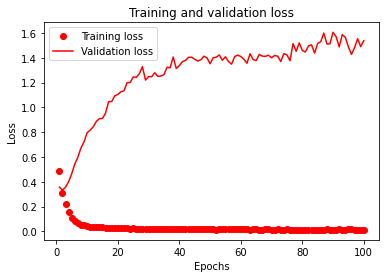

Epoch 1/3
366/366 [==============================] - 2s 5ms/step - loss: 0.5173 - accuracy: 0.6340 - val_loss: 0.3509 - val_accuracy: 0.7534
Epoch 2/3
366/366 [==============================] - 2s 4ms/step - loss: 0.2871 - accuracy: 0.8085 - val_loss: 0.3175 - val_accuracy: 0.8012
Epoch 3/3
92/92 [==============================] - 0s 2ms/step - loss: 0.3486 - accuracy: 0.7964

[test loss, test accuracy]: [0.34858500957489014, 0.7964481115341187]


In [ ]:
#============== Search Best Epoch ====================
model =  tuner.hypermodel.build(best_model)
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_tests,y_tests))
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('best epochs\t = ',best_epoch)

plt.plot(range(1,len(history.history['loss'])+1),
         history.history['loss'], 'ro', label='Training loss')
plt.plot(range(1,len(history.history['val_loss'])+1),
         history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#============== Rerun the best hyperparameter and epoch ====================
hypermodel = tuner.hypermodel.build(best_model)
hypermodel.fit(x_train,y_train,epochs=best_epoch,validation_data=(x_tests,y_tests))
eval_result = hypermodel.evaluate(x_tests,y_tests)

print("\n[test loss, test accuracy]:", eval_result)

#============== Save The best epoch ====================
!mkdir -p used_model
hypermodel.save('used_model/sentiment_model.h5')

#===============Save Tokenizer==============
with open('used_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('used_model/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


##**For User**

This section is the code that can be used to perform prediction based on the tweet outside the dataset. The input tweets need to be tokenize with the same tokenizer we done before. In order to save and load the tokenizer we used **pickle** package in which o got from stack overflow thread [here](https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring).

After we tokenize the input we can predict the input. The result wil be in form of binary that represent this array [positive, neutral, negative]. By translating those array, the result can be determined.

We can also retrain the model with the dataset we create. All we need is a DataFrame with column of **'text'** and **'sentiment : [positive, neutral,negative]'**. The process to re train the project includes : **preprocess dataset -> Tokenize Binarily -> Fit with this code**



```
model.fit(x_train, y_train, epochs=best_epoch,  validation_split=0.2)
```

Best epoch is the best_epoch used to train the precursor model. and validation split is the percentage of data that will be used as model validation. Remember to always used the same tokenizer, otherwise, you should re-tune your model with the precursor dataset to search new hyperparameter.



In [ ]:
User_model =  tf.keras.models.load_model('used_model/sentiment_model.h5')
with open('used_model/tokenizer.pickle', 'rb') as handle:
    tokenizer_user = pickle.load(handle)
with open('used_model/encoder.pickle', 'rb') as handle:
    encoder_user = pickle.load(handle)
word = pd.DataFrame([input('Tweets = ')],columns=['text'])

word = text_conditioning(word,['text'],['@','http','#','&gt','&amp','RT'],plot=False)

x_pred = tokenizer_user.texts_to_matrix(word['text'].values,mode='tfidf')

y_pred = User_model.predict(x_pred)
y_pred=np.round(np.array(y_pred))
print('\nThat seems like a ',encoder_user.inverse_transform(y_pred)[0],' word')


Tweets = amazing flight i've never forget this experience flying with @airamerica #flytothemoon

That seems like a  positive  word


#**$2^{nd}$ model**#

##**X**
*   **text** = What the tweet said

##**Y2**
Predict the impact of such tweets according to the rate of Re-tweet
*   **retweet_count** = Tweet impact